# Problem Set 1

In [142]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from utils import get_naics_descriptions
import warnings
warnings.filterwarnings("ignore")

## Exploring the data

In [143]:
firm_data = pd.read_stata('firmdata.dta')

firm_data["year"] = pd.to_datetime(firm_data["year"], format='%Y').dt.year
firm_data = firm_data.astype({
    "firmid": int,
    "sales": int,
    "operatingexpenses": int
})

firm_data = get_naics_descriptions(firm_data)

firm_data.head()

,year,naics,firmid,sales,operatingexpenses,naics_name
0,1995,111150,1300,2029,1577,Corn Farming
1,1995,111150,2453,423,374,Corn Farming
2,1995,111150,208,32,32,Corn Farming
3,1995,111219,1923,73,106,Other Vegetable (except Potato) and Melon Farming
4,1995,111219,459,19,34,Other Vegetable (except Potato) and Melon Farming


In [144]:
firm_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83476 entries, 0 to 83475
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   year               83476 non-null  int32 
 1   naics              83476 non-null  int32 
 2   firmid             83476 non-null  int64 
 3   sales              83476 non-null  int64 
 4   operatingexpenses  83476 non-null  int64 
 5   naics_name         66219 non-null  object
dtypes: int32(2), int64(3), object(1)
memory usage: 3.2+ MB


In [145]:
firm_data.describe()

,year,naics,firmid,sales,operatingexpenses
count,83476.000000,83476.000000,83476.000000,83476.000000,83476.000000
mean,2004.373928,408472.043294,4420.863278,2813.938845,2374.860499
std,6.002737,122705.928674,2845.303086,15771.277642,13607.753584
min,1995.000000,111150.000000,1.000000,1.000000,1.000000
25%,1999.000000,332311.000000,1776.750000,57.000000,53.000000
50%,2004.000000,336120.000000,4304.500000,250.000000,215.000000
75%,2009.000000,511210.000000,6786.000000,1133.000000,960.000000
max,2015.000000,813910.000000,9864.000000,568915.000000,504779.000000


## Number of firms in the economy

(1995.0, 2015.0)

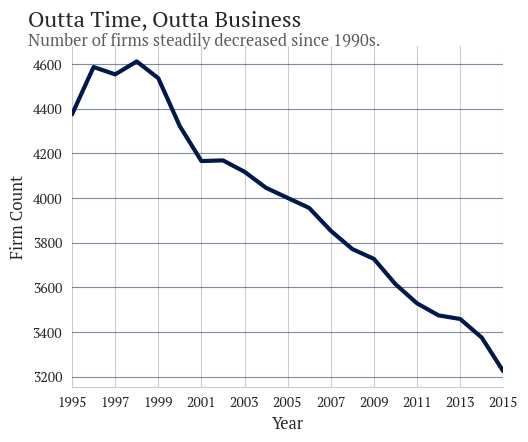

In [156]:
firm_count_by_year = pd.DataFrame(firm_data.groupby("year")["firmid"].nunique()).reset_index()

fig, ax = plt.subplots(figsize=(5, 4))

fig.text(0, 1, "Outta Time, Outta Business", fontsize=16, fontfamily='PT Serif')
fig.text(0, 0.95, "Number of firms steadily decreased since 1990s.", fontsize=12, alpha=0.75, fontfamily='PT Serif')

fig.tight_layout()

ax.set_xlabel("Year", fontfamily='PT Serif', fontsize=12)
ax.set_ylabel("Firm Count", fontfamily='PT Serif', fontsize=12)

ax.plot(firm_count_by_year["year"], firm_count_by_year["firmid"], color='#001949', linewidth=3)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

ax.yaxis.grid(True, color='#001949', alpha=0.5)

ax.set_xticks(firm_count_by_year["year"][::2])
ax.set_xticklabels(firm_count_by_year["year"][::2], fontfamily='PT Serif')

y_ticks = [tick.astype(int) for tick in ax.get_yticks()]

ax.set_yticklabels(y_ticks, fontfamily='PT Serif')

ax.set_xlim(left=firm_count_by_year["year"].min(), right=firm_count_by_year["year"].max())

## Market concentration

In [147]:
def calculate_industry_HHI(df):
    df = df.copy()
    df["market_share"] = df["sales"] / df["sales"].sum()
    df["HHI"] = (df["market_share"] ** 2).sum()
    return df

HHI_df_long = firm_data.groupby(["year", "naics"]).apply(calculate_industry_HHI).reset_index(drop=True)

HHI_df = HHI_df_long[['year', 'naics', 'HHI']].drop_duplicates()

HHI_df.head()

,year,naics,HHI
0,1995,111150,0.696372
3,1995,111219,0.672259
5,1995,111335,0.534626
7,1995,111339,0.401144
10,1995,111411,1.000000


In [148]:
avg_HHI_df = HHI_df.groupby("year")["HHI"].mean().reset_index()

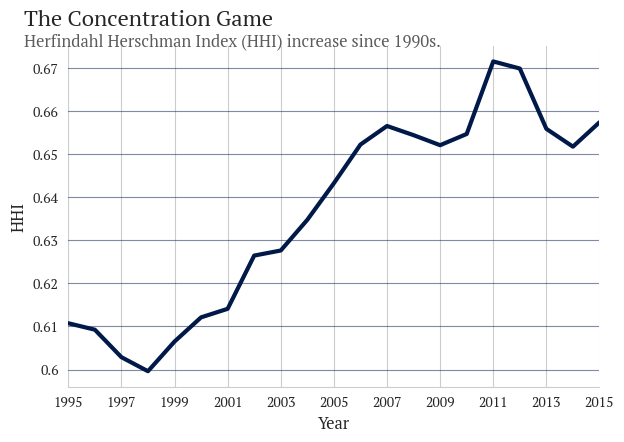

In [149]:
fig, ax = plt.subplots(figsize=(6, 4))

fig.text(0, 1, "The Concentration Game", fontsize=16, fontfamily='PT Serif')
fig.text(0, 0.95, "Herfindahl Herschman Index (HHI) increase since 1990s.", fontsize=12, alpha=0.75, fontfamily='PT Serif')

fig.tight_layout()

ax.set_xlabel("Year", fontfamily='PT Serif', fontsize=12)
ax.set_ylabel("HHI", fontfamily='PT Serif', fontsize=12)

ax.plot(avg_HHI_df["year"], avg_HHI_df["HHI"], color='#001949', linewidth=3)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

ax.yaxis.grid(True, color='#001949', alpha=0.5)

ax.set_xticks(avg_HHI_df["year"][::2])
ax.set_xticklabels(avg_HHI_df["year"][::2], fontfamily='PT Serif')

ax.set_yticklabels([round(tick, 2) for tick in ax.get_yticks()], fontfamily='PT Serif')

ax.set_xlim(left=avg_HHI_df["year"].min(), right=avg_HHI_df["year"].max())

plt.show()

In [150]:
def calculate_average_cr(df, num):
    # Calculate market shares within each industry-year
    df['total_industry_sales'] = df.groupby(['year', 'naics'])['sales'].transform('sum')
    df['market_share'] = df['sales'] / df['total_industry_sales']
    
    # For each industry-year, get sum of top 4 market shares
    cr4 = df.groupby(['year', 'naics'])['market_share'] \
            .nlargest(num) \
            .groupby(['year', 'naics']) \
            .sum() \
            .reset_index()
    
    # Calculate average CR4 across all industries for each year
    avg_cr4 = cr4.groupby('year')['market_share'].mean().reset_index()
    return avg_cr4

avg_cr4_data = calculate_average_cr(firm_data, 4)

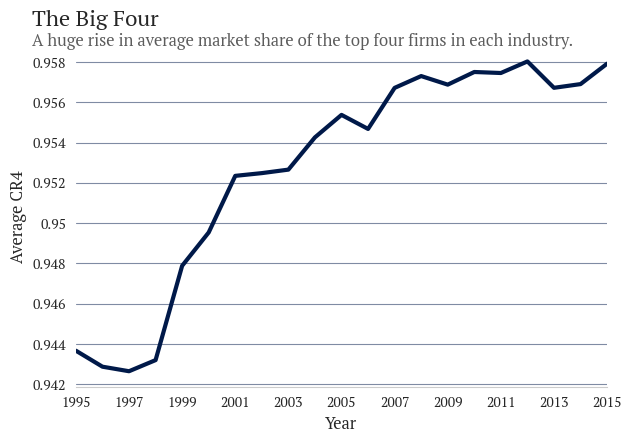

In [151]:
fig, ax = plt.subplots(figsize=(6, 4))

fig.text(0, 1, "The Big Four", fontsize=16, fontfamily='PT Serif')
fig.text(0, 0.95, "A huge rise in average market share of the top four firms in each industry.", fontsize=12, alpha=0.75, fontfamily='PT Serif')

fig.tight_layout()

ax.set_xlabel("Year", fontfamily='PT Serif', fontsize=12)
ax.set_ylabel("Average CR4", fontfamily='PT Serif', fontsize=12)

ax.plot(avg_cr4_data["year"], avg_cr4_data["market_share"], color='#001949', linewidth=3)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)

ax.xaxis.grid(False)
ax.yaxis.grid(True, color='#001949', alpha=0.5)

ax.set_xticks(avg_cr4_data["year"][::2])
ax.set_xticklabels(avg_cr4_data["year"][::2], fontfamily='PT Serif')

ax.set_yticklabels([round(tick, 3) for tick in ax.get_yticks()], fontfamily='PT Serif')

ax.set_xlim(left=avg_cr4_data["year"].min(), right=avg_cr4_data["year"].max())

plt.show()

## Scale without mass

In [152]:
def cr_operatingexpenses(df, num):
    # Calculate market shares within each industry-year
    df['total_industry_opex'] = df.groupby(['year', 'naics'])['operatingexpenses'].transform('sum')
    df['total_industry_sales'] = df.groupby(['year', 'naics'])['sales'].transform('sum')
    df['opex_market_share'] = df['operatingexpenses'] / df['total_industry_opex']
    df['sales_market_share'] = df['sales'] / df['total_industry_sales']
    
    # Get indices of top 4 companies by sales market share
    top_indices = df.groupby(['year', 'naics'])['sales_market_share'] \
                   .nlargest(num) \
                   .reset_index(level=[0,1], drop=True) \
                   .index
    
    # Use these indices to get operating expense market shares of same companies
    cr4 = df.loc[top_indices].groupby(['year', 'naics'])['opex_market_share'] \
          .sum() \
          .reset_index()
    
    # Calculate average CR4 across all industries for each year
    avg_cr4 = cr4.groupby('year')['opex_market_share'].mean().reset_index()
    return avg_cr4

In [153]:
avg_cr4_operatingexpenses = cr_operatingexpenses(firm_data, 4)
avg_cr4_data_merged = avg_cr4_data.merge(avg_cr4_operatingexpenses, on='year')

In [154]:
def cr_sales_and_opex(df, num):
    # Calculate market shares within each industry-year
    df['total_industry_opex'] = df.groupby(['year', 'naics'])['operatingexpenses'].transform('sum')
    df['total_industry_sales'] = df.groupby(['year', 'naics'])['sales'].transform('sum')
    df['sales_market_share'] = df['sales'] / df['total_industry_sales']
    
    # Get indices of top 4 companies by sales market share
    top_indices = df.groupby(['year', 'naics'])['sales_market_share'] \
                   .nlargest(num) \
                   .reset_index(level=[0,1], drop=True) \
                   .index
    
    # Use these indices to get operating expense market shares of same companies
    cr4_sales = df.loc[top_indices].groupby(['year', 'naics'])['sales'] \
          .sum() \
          .reset_index()
    
    cr4_opex = df.loc[top_indices].groupby(['year', 'naics'])['operatingexpenses'] \
          .sum() \
          .reset_index()
          
    cr4 = cr4_sales.merge(cr4_opex, on=['year', 'naics'])
    total_cr4 = cr4.groupby('year').sum().reset_index()

    return total_cr4

cr4_sales_opex_df = cr_sales_and_opex(firm_data, 4)

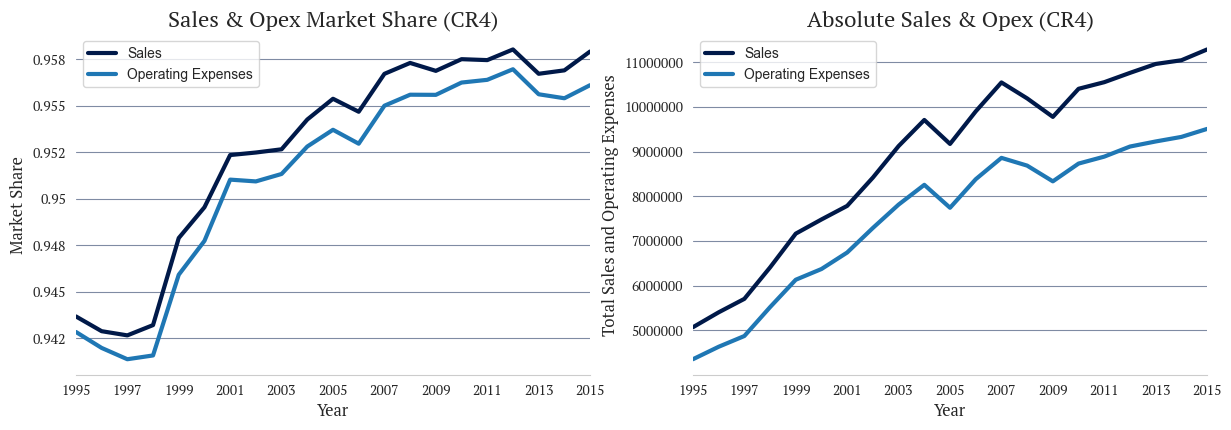

In [155]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

fig.tight_layout()

plt.subplots_adjust(wspace=0.2)

ax1.set_title("Sales & Opex Market Share (CR4)", fontfamily='PT Serif', fontsize=16)

ax1.set_xlabel("Year", fontfamily='PT Serif', fontsize=12)
ax1.set_ylabel("Market Share", fontfamily='PT Serif', fontsize=12)

ax1.plot(avg_cr4_data_merged["year"], avg_cr4_data_merged["market_share"], label='Sales', color='#001949', linewidth=3)
ax1.plot(avg_cr4_data_merged["year"], avg_cr4_data_merged["opex_market_share"], label='Operating Expenses', linewidth=3)

ax1.spines['top'].set_visible(False)
ax1.spines['left'].set_visible(False)
ax1.spines['right'].set_visible(False)

ax1.xaxis.grid(False)
ax1.yaxis.grid(True, color='#001949', alpha=0.5)

ax1.set_xticks(avg_cr4_data_merged["year"][::2])
ax1.set_xticklabels(avg_cr4_data_merged["year"][::2], fontfamily='PT Serif')
ax1.set_yticklabels([round(tick, 3) for tick in ax1.get_yticks()], fontfamily='PT Serif')

ax1.set_xlim(left=avg_cr4_data["year"].min(), right=avg_cr4_data["year"].max())

ax1.legend()

ax2.set_title("Absolute Sales & Opex (CR4)", fontfamily='PT Serif', fontsize=16)

ax2.set_xlabel("Year", fontfamily='PT Serif', fontsize=12)
ax2.set_ylabel("Total Sales and Operating Expenses", fontfamily='PT Serif', fontsize=12)

ax2.plot(cr4_sales_opex_df["year"], cr4_sales_opex_df["sales"], label='Sales', color='#001949', linewidth=3)
ax2.plot(cr4_sales_opex_df["year"], cr4_sales_opex_df["operatingexpenses"], label='Operating Expenses', linewidth=3)

ax2.spines['top'].set_visible(False)
ax2.spines['left'].set_visible(False)
ax2.spines['right'].set_visible(False)

ax2.xaxis.grid(False)
ax2.yaxis.grid(True, color='#001949', alpha=0.5)

ax2.set_xticks(avg_cr4_data_merged["year"][::2])
ax2.set_xticklabels(avg_cr4_data_merged["year"][::2], fontfamily='PT Serif')
ax2.set_yticklabels([tick.astype(int) for tick in ax2.get_yticks()], fontfamily='PT Serif')

ax2.set_xlim(left=avg_cr4_data["year"].min(), right=avg_cr4_data["year"].max())

ax2.legend()